In [380]:
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import os
import pandas as pd
import matplotlib.pyplot as plt
from algotrader.data.downloader import CLEANED_DIR


symbol = "BTCUSDT"
# symbol = "ETHBTC"

df_files = [f for f in os.listdir(os.path.join(CLEANED_DIR, symbol)) if "klines" in f]
df = pd.concat([pd.read_parquet(os.path.join(CLEANED_DIR, symbol, f))[["Open_time", "Open", "High", "Low", "Close"]] for f in df_files], axis=0)

df = df.rename(columns={"Open_time": "Time"}).assign(Time=pd.to_datetime(df.Open_time, unit='ms')).set_index("Time")
df.shape

(15638400, 4)

In [381]:
df = df.assign(
    ewma200 = df.Close.ewm(halflife=200).mean(),
    macd = df.Close.ewm(halflife=12).mean() - df.Close.ewm(halflife=26).mean()
)
df = df.assign(
    macd_signal = df.macd - df.macd.ewm(halflife=9).mean()
).drop(columns=["macd"])
df.head()

,Open,High,Low,Close,ewma200,macd_signal
Time,,,,,,
2024-01-01 00:00:00,42283.58,42283.59,42283.58,42283.58,42283.580000,0.000000
2024-01-01 00:00:01,42283.59,42283.59,42283.58,42283.58,42283.580000,0.000000
2024-01-01 00:00:02,42283.58,42283.59,42283.58,42283.58,42283.580000,0.000000
2024-01-01 00:00:03,42283.58,42283.59,42283.58,42283.59,42283.582513,0.000086
2024-01-01 00:00:04,42283.58,42283.59,42283.58,42283.59,42283.584021,0.000119


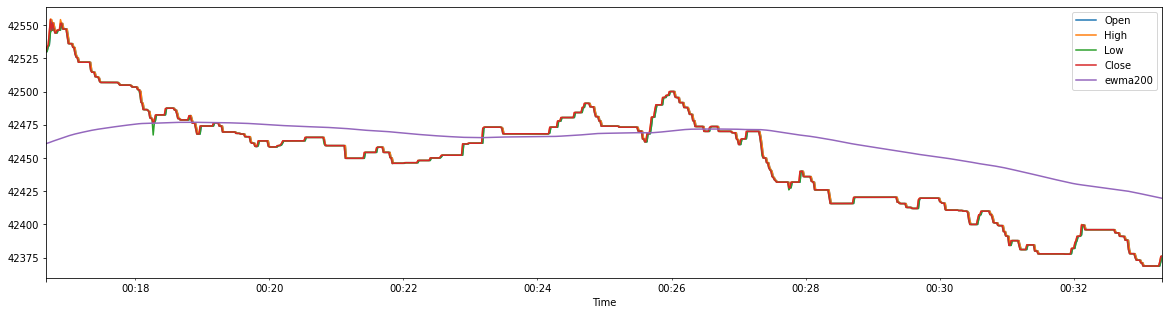

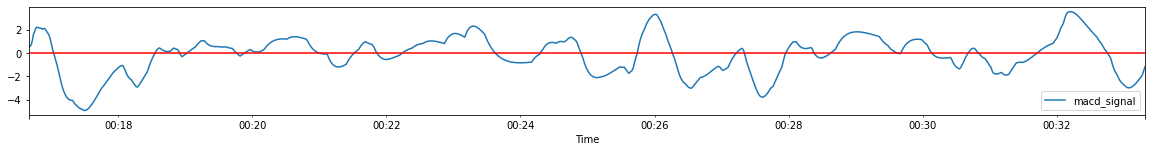

In [382]:
_ = df.iloc[1000:2000][["Open", "High", "Low", "Close", "ewma200"]].plot(figsize=(20, 5))

p = df.iloc[1000:2000][["macd_signal"]].plot(figsize=(20, 2))
p.axhline(0, color = "red")

In [383]:
# df_test = df.loc["2024-01-01"].copy()
df_test = df.loc["2024-06-02"].copy()

trades = {"time": [], "trade_price": [], "quantity": []}
inlong, inshort = False, False

RR = 1.5
risk = 0.001
profit_target, loss_target = 0, 0

for i in range(1, df_test.shape[0] - 1):

    row, prev_row = df_test.iloc[i], df_test.iloc[i-1]

    # active position
    if inlong:
        if row.Open >= profit_target or row.High >= profit_target or row.Low >= profit_target or row.Close >= profit_target:
            trades["time"].append(row.name)
            trades["trade_price"].append(profit_target)
            trades["quantity"].append(-1)
            inlong, inshort = False, False
        elif row.Open <= loss_target or row.High <= loss_target or row.Low <= loss_target or row.Close <= loss_target:
            trades["time"].append(row.name)
            trades["trade_price"].append(loss_target)
            trades["quantity"].append(-1)
            inlong, inshort = False, False

        continue

    elif inshort:
        if row.Open <= profit_target or row.High <= profit_target or row.Low <= profit_target or row.Close <= profit_target:
            trades["time"].append(row.name)
            trades["trade_price"].append(profit_target)
            trades["quantity"].append(1)
            inlong, inshort = False, False
        elif row.Open >= loss_target or row.High >= loss_target or row.Low >= loss_target or row.Close >= loss_target:
            trades["time"].append(row.name)
            trades["trade_price"].append(loss_target)
            trades["quantity"].append(1)
            inlong, inshort = False, False

        continue

    # buy
    if prev_row.macd_signal < 0 and row.macd_signal > 0 and row.ewma200 < row.Close:
        trades["time"].append(df_test.iloc[i+1].name)
        trades["trade_price"].append(df_test.iloc[i+1].Open)
        trades["quantity"].append(1)
        inlong = True
        inshort = False
        profit_target = df_test.iloc[i+1].Open * (1 + risk * RR)
        loss_target = df_test.iloc[i+1].Open * (1 - risk)
    # sell
    elif prev_row.macd_signal > 0 and row.macd_signal < 0 and row.ewma200 > row.Close:
        trades["time"].append(df_test.iloc[i+1].name)
        trades["trade_price"].append(df_test.iloc[i+1].Open)
        trades["quantity"].append(-1)
        inlong = False
        inshort = True
        profit_target = df_test.iloc[i+1].Open * (1 - risk * RR)
        loss_target = df_test.iloc[i+1].Open * (1 + risk)

trade_log = pd.DataFrame.from_dict(trades, orient="columns")
trade_log["cash"] = trade_log.eval("trade_price * quantity * -1").cumsum()

Number of trades: 83
Win Rate: 38.55421686746988 %
PnL: -136.4029199998913


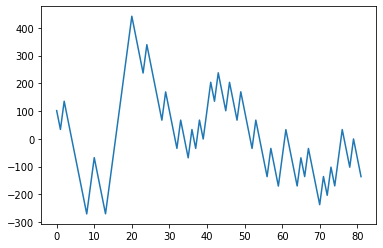

In [397]:
entry_exit = pd.concat([
    trade_log.iloc[::2].drop(columns=["cash"]).reset_index(),
    trade_log.iloc[1::2].drop(columns=["cash"]).reset_index().rename(columns={"time": "exit_time", "trade_price": "exit_price", "quantity":"exit_quantity"})
], axis=1).drop(columns=["index"])

entry_exit["profit"] = entry_exit.eval("(exit_price - trade_price) * quantity")
print("Number of trades:", entry_exit.shape[0])
print("Win Rate:", (entry_exit.profit > 0).sum() / entry_exit.shape[0] * 100, "%")
print("PnL:", entry_exit["profit"].sum())

_ = entry_exit.profit.cumsum().plot()

PnL: -75.88291999988724
Sharpe: nan


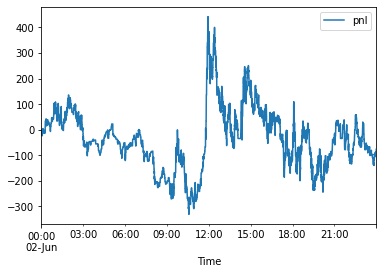

In [398]:
pta_df = df_test.reset_index().merge(trade_log, left_on="Time", right_on="time", how="left").drop(columns=["time"]).set_index("Time")
pta_df = pta_df.assign(
    portfolio = pta_df.quantity.fillna(0).cumsum() * pta_df.Close,
    cash = pta_df.cash.ffill()
)
pta_df["pnl"] = pta_df.eval("portfolio + cash").diff()

print("PnL:", pta_df["pnl"].sum())

daily_pnl = pta_df["pnl"].groupby(pta_df.index.date).sum()
print("Sharpe:", daily_pnl.mean() * 252 / daily_pnl.std())

_ = pta_df[["pnl"]].cumsum().plot()

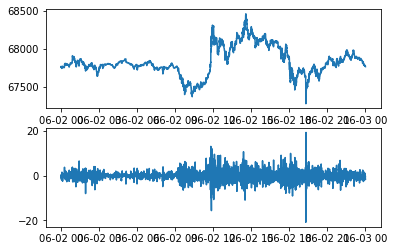

In [386]:
_, ax = plt.subplots(2, 1)
ax[0].plot(pta_df.Close)
ax[1].plot(pta_df.macd_signal)